You are a data scientist working for a healthcare company, and you have been tasked with creating a
decision tree to help identify patients with diabetes based on a set of clinical variables. You have been
given a dataset (diabetes.csv) with the following variables:
1. Pregnancies: Number of times pregnant (integer)
2. Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test (integer)
3. BloodPressure: Diastolic blood pressure (mm Hg) (integer)
4. SkinThickness: Triceps skin fold thickness (mm) (integer)
5. Insulin: 2-Hour serum insulin (mu U/ml) (integer)
6. BMI: Body mass index (weight in kg/(height in m)^2) (float)
7. DiabetesPedigreeFunction: Diabetes pedigree function (a function which scores likelihood of diabetes
based on family history) (float)
8. Age: Age in years (integer)
9. Outcome: Class variable (0 if non-diabetic, 1 if diabetic) (integer)

Here’s the dataset link: [Diabaties_dataset](https://drive.google.com/file/d/1Q4J8KS1wm4-_YTuc389enPh6O-eTNcx2/view?usp=sharing)

Your goal is to create a decision tree to predict whether a patient has diabetes based on the other
variables. Here are the steps you can follow:

# <div style="padding: 15px; background-color: #29ADB2; margin: 15px; color: #000000; font-family: 'New Times Roman', serif; font-size: 110%; text-align: center; border-radius: 10px; overflow: hidden; font-weight: bold;"> Importing Imp. Libraries </div>

In [2]:
pip install feature-engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 9.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# From feature engine
from feature_engine.outliers import OutlierTrimmer
from feature_engine.outliers import Winsorizer
from feature_engine.imputation import MeanMedianImputer

#from sklearn
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

`Question 1`.Import the dataset and examine the variables. Use descriptive statistics and visualizations to
understand the distribution and relationships between the variables. 

`Answer` :

In [34]:
df = pd.read_csv('diabetes.csv')

In [35]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [37]:
#Check data types in df

numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']

discrete_features = [feature for feature in numerical_features if len(df[feature].unique())<25]

continuous_features = [feature for feature in numerical_features if feature not in discrete_features]

categorical_features = [feature for feature in df.columns if feature not in numerical_features]

binary_categorical_features = [feature for feature in categorical_features if len(df[feature].unique()) <=3]

print(f"Numerical Features Count {len(numerical_features)}")
print(f"Discrete features Count {len(discrete_features)}")
print(f"Continuous features Count {len(continuous_features)}")
print(f"Categorical features Count {len(categorical_features)}")
print(f"Binary Categorical features Count {len(binary_categorical_features)}")

Numerical Features Count 9
Discrete features Count 2
Continuous features Count 7
Categorical features Count 0
Binary Categorical features Count 0


In [38]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


***there are lot of zeros in many colums , we can replce them with mwdian/mean in next section***

`Question 2`. Preprocess the data by cleaning missing values, removing outliers, and transforming categorical
variables into dummy variables if necessary.

`Answer` :

In [39]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [40]:
#imputing zeros with mean:

def zeros_imputer(df, columns):
    for column  in columns:
        df[column] = df[column].replace( to_replace= 0 , value= df[column].median())
zeros_imputer(df, continuous_features)

***No missing values in dataset***

In [41]:
#lest draw boxplot to chexk outliers
def draw_boxplots(dataframe, column_names):
    """
    Draw subplots with box plots for numerical columns in a DataFrame to identify outliers.

    Parameters:
    - dataframe: pandas DataFrame
    - column_names: list of str, names of the numerical columns in the DataFrame

    Returns:
    - None (displays the subplots with box plots)
    """
    num_cols = len(column_names)
    num_rows = (num_cols + 1) // 2  # Ensure an extra row if the number of columns is odd
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 5 * num_rows))  # Adjust the figsize as needed

    for i, column_name in enumerate(column_names):
        row_idx = i // 2
        col_idx = i % 2
        sns.boxplot(x=dataframe[column_name], ax=axes[row_idx, col_idx])
        axes[row_idx, col_idx].set_title(f'Box Plot of {column_name}')

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()


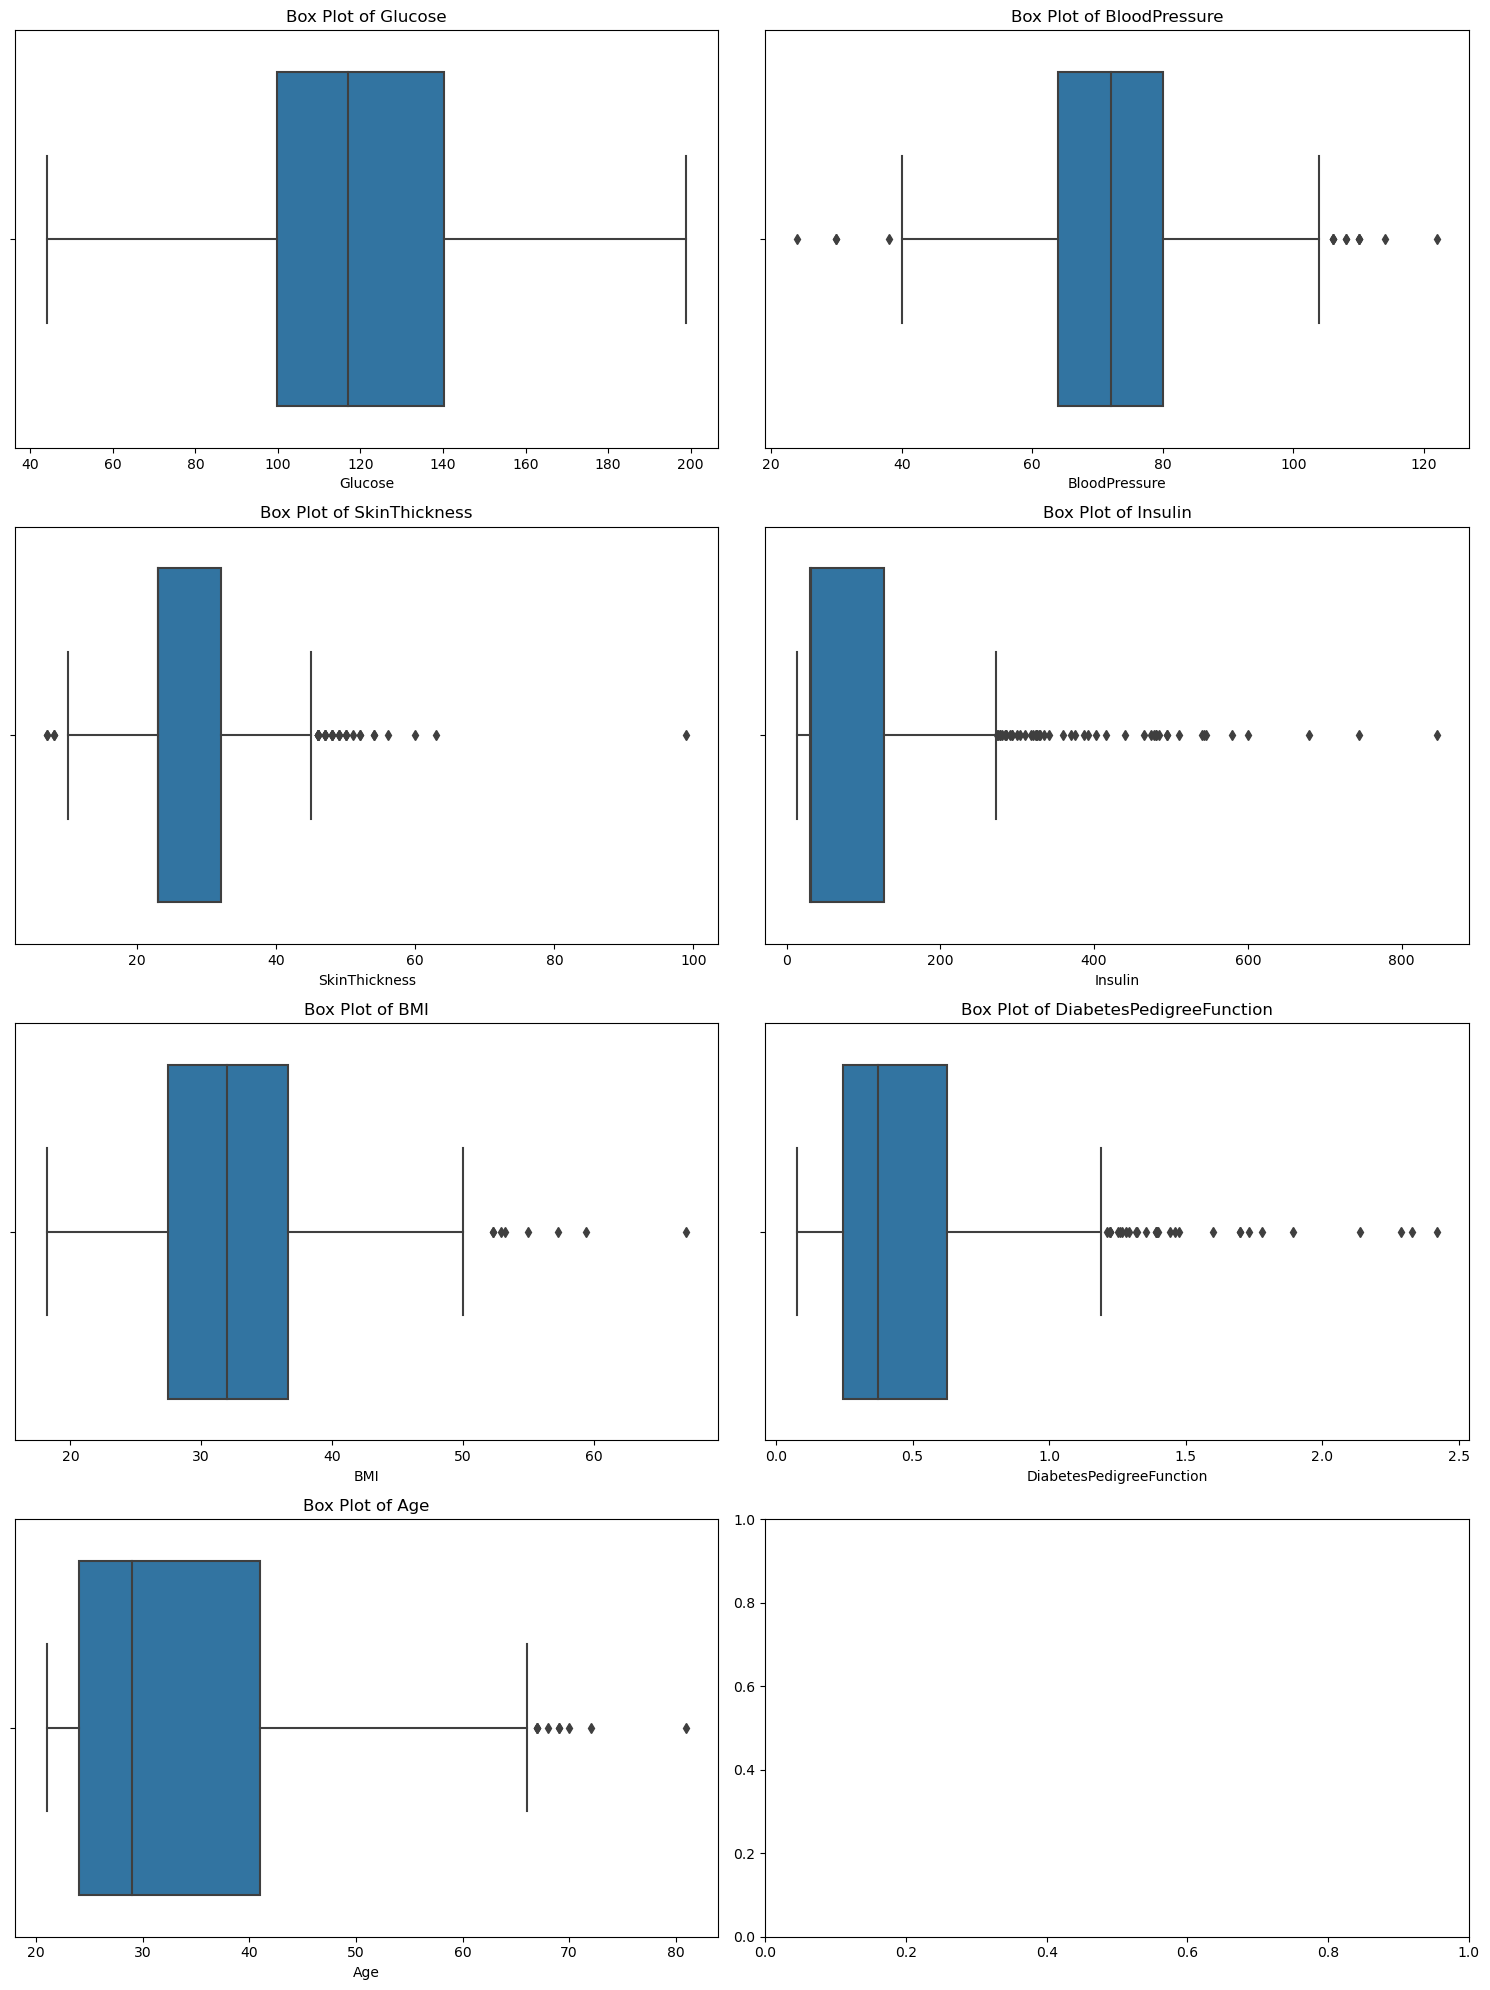

In [42]:
draw_boxplots(df, continuous_features)

<AxesSubplot: >

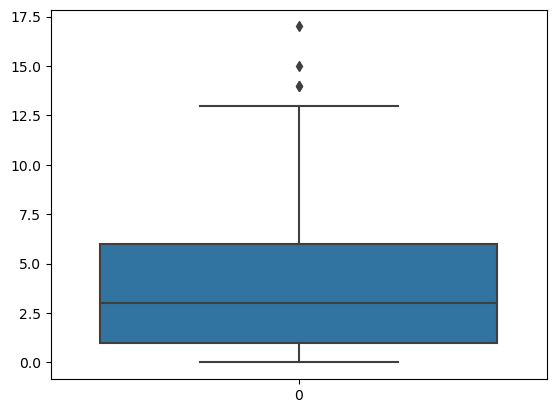

In [31]:
sns.boxplot(df['Pregnancies'])

***Here in ['Glucose', 'SkinThickness', 'BloodPressure', 'Pregnancies'] having less outiler we can drop/trim those colums from dataset, but in ['Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'] we can see a large no. of outliers droping these will impact our model performance so i will crap the outlier using feature engine.***

In [47]:
trimmer = OutlierTrimmer(
    variables=['Glucose', 'BloodPressure', 'Pregnancies'],
    capping_method="iqr",
    tail="both",
    fold=1.5,
)

df = trimmer.fit_transform(df)

In [55]:
capper = Winsorizer(
    variables=['Insulin', 'BMI', 'Age', 'SkinThickness', 'DiabetesPedigreeFunction'],
    capping_method="iqr",
    tail="both",
    fold=0.05,
)

df = capper.fit_transform(df)

In [56]:
continuous_features

['Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

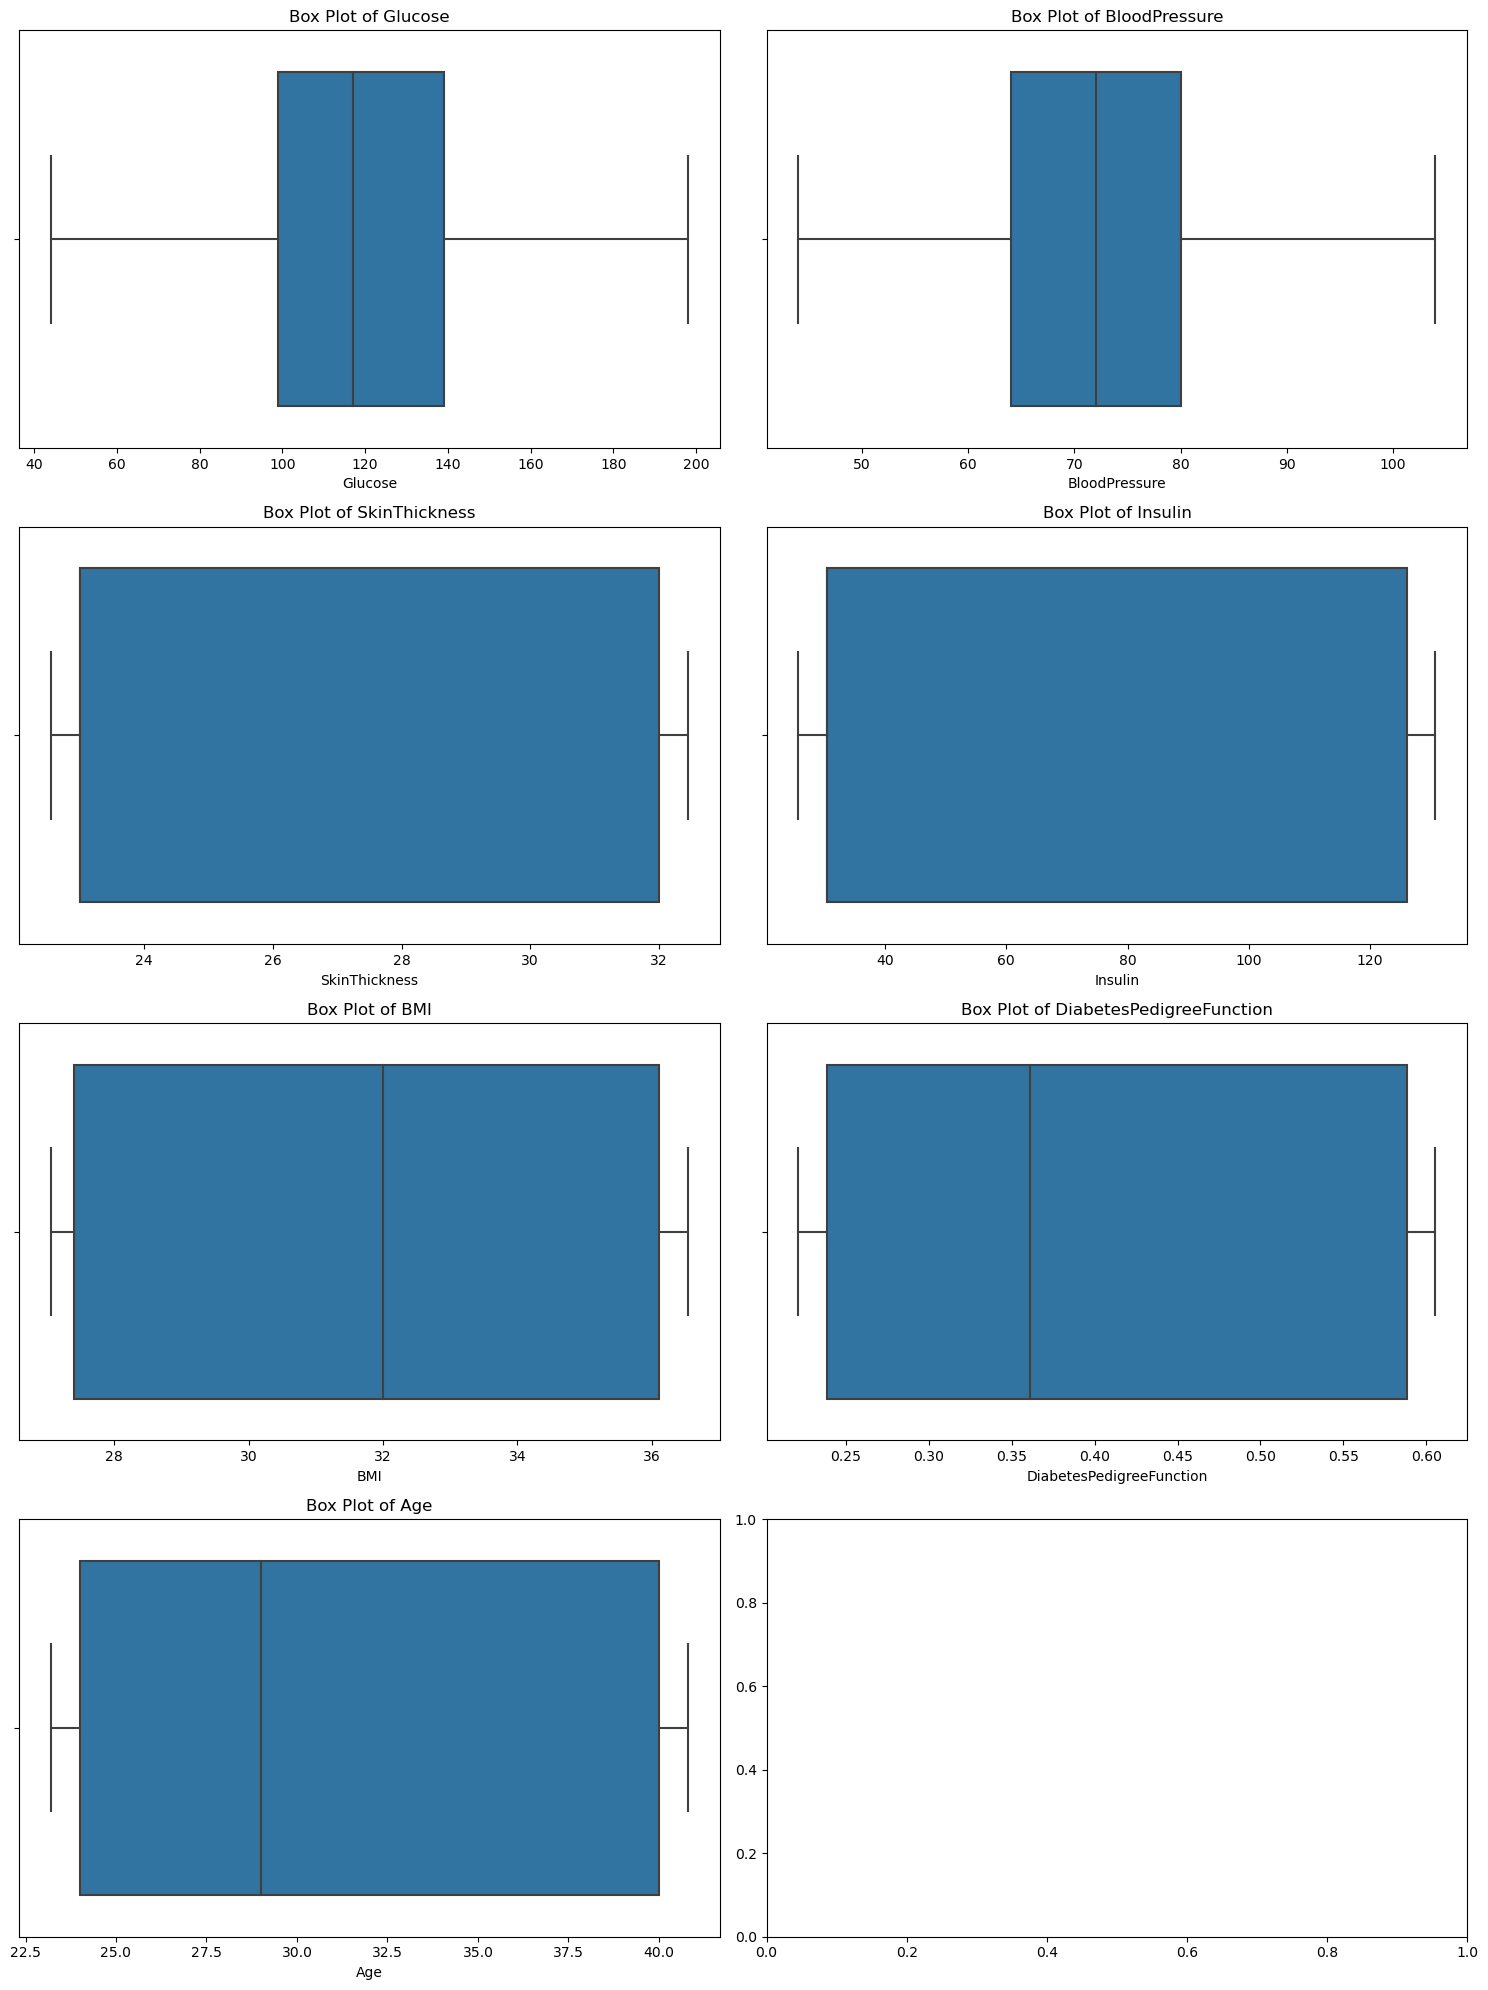

In [57]:
draw_boxplots(df, continuous_features)

<AxesSubplot: >

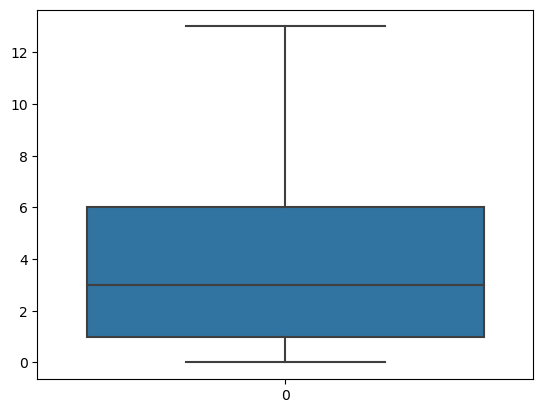

In [58]:
sns.boxplot(df['Pregnancies'])

`Question 3`. Split the dataset into a training set and a test set. Use a random seed to ensure reproducibility.

`Answer` :

In [59]:
X = df.iloc[:, :-1]
y = df.iloc[:,-1]

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

`Question 4`. Use a decision tree algorithm, such as ID3 or C4.5, to train a decision tree model on the training set. Use
cross-validation to optimize the hyperparameters and avoid overfitting.

`Answer` :

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score


# Create a decision tree classifier
dt_classifier = DecisionTreeClassifier()

# Define a parameter grid to search for the best hyperparameters
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Use GridSearchCV for hyperparameter tuning with cross-validation
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [62]:
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [63]:
# Train the decision tree model with the best hyperparameters
best_dt_classifier = DecisionTreeClassifier(**best_params)
best_dt_classifier.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = best_dt_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy)

Test Set Accuracy: 0.7172413793103448


`Question 5`. Evaluate the performance of the decision tree model on the test set using metrics such as accuracy,
precision, recall, and F1 score. Use confusion matrices and ROC curves to visualize the results.

`Answer` :

In [64]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [65]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.78        94
           1       0.60      0.59      0.59        51

    accuracy                           0.72       145
   macro avg       0.69      0.69      0.69       145
weighted avg       0.72      0.72      0.72       145



In [66]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[74 20]
 [21 30]]


In [67]:
# ROC Curve
y_prob = best_dt_classifier.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

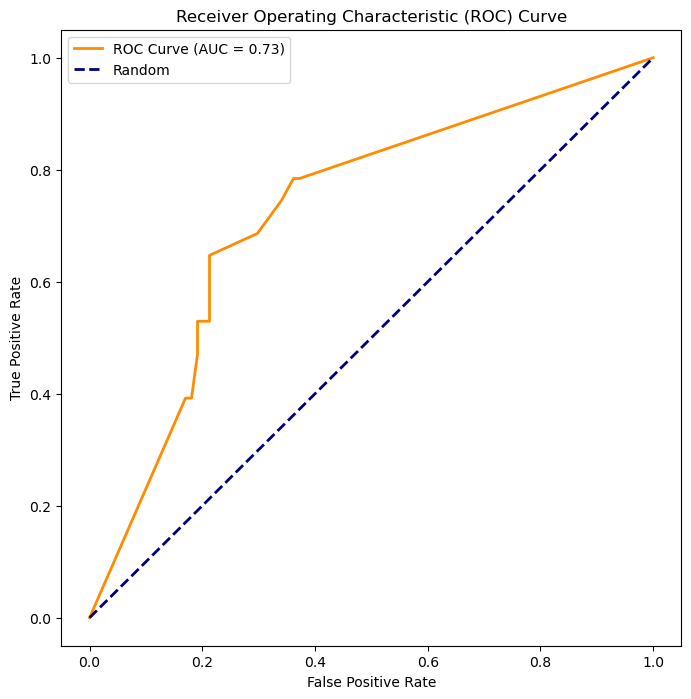

In [68]:

# Plot ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

`Question 6`. Interpret the decision tree by examining the splits, branches, and leaves. Identify the most important
variables and their thresholds. Use domain knowledge and common sense to explain the patterns and
trends.

`Answer` :

Pregnancies: 0.06973705174673785
Glucose: 0.4344287486836735
BloodPressure: 0.15330466117977418
SkinThickness: 0.010085263438727227
Insulin: 0.06886759159946067
BMI: 0.11643203719555995
DiabetesPedigreeFunction: 0.06335860053412593
Age: 0.0837860456219407


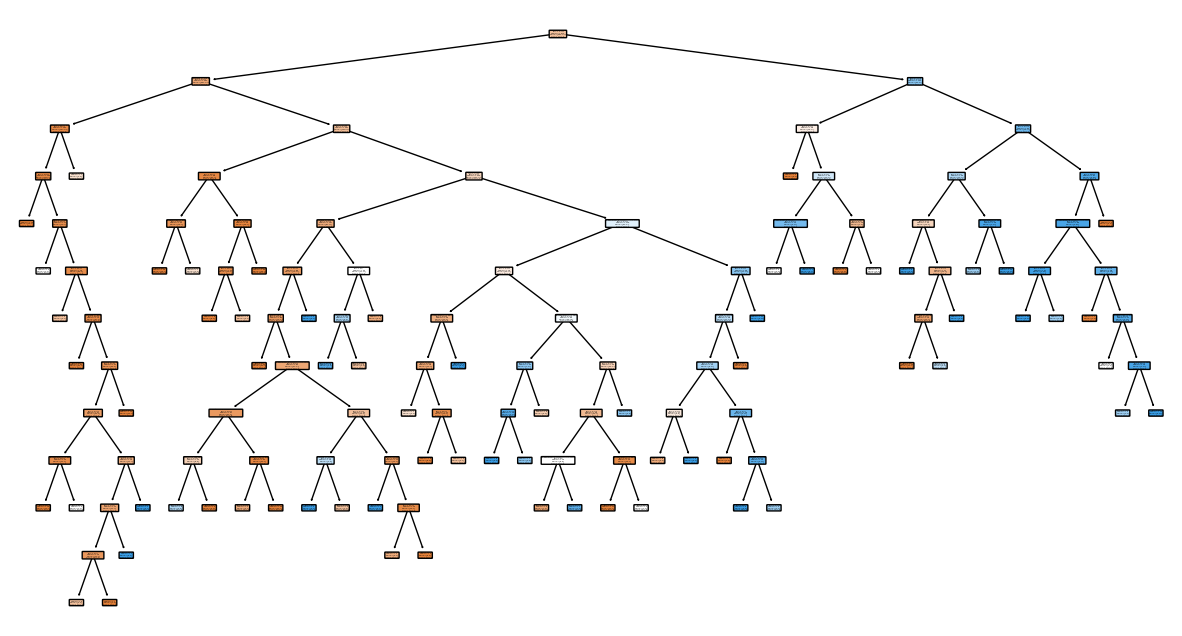

In [69]:
#  Identify the most important variables and their thresholds
feature_names = X_train.columns
tree_feature_importance = best_dt_classifier.feature_importances_

# Display feature importance
for feature, importance in zip(feature_names, tree_feature_importance):
    print(f"{feature}: {importance}")

# Visualize the decision tree (optional)
from sklearn.tree import plot_tree
plt.figure(figsize=(15, 8))
plot_tree(best_dt_classifier, feature_names=feature_names, class_names=['class_0', 'class_1'], filled=True, rounded=True)
plt.show()



1. **Glucose (0.434):**
   - Glucose has the highest importance score, suggesting that it is a crucial factor in predicting diabetes. This aligns with common medical knowledge as high glucose levels are a key indicator of diabetes.

2. **BMI (0.116):**
   - Body Mass Index (BMI) also has a relatively high importance score. High BMI is often associated with insulin resistance and type 2 diabetes.

3. **Age (0.084):**
   - Age is another important variable, which is consistent with the understanding that the risk of diabetes tends to increase with age.

4. **Blood Pressure (0.153):**
   - Blood pressure is moderately important. Hypertension is a risk factor for diabetes, and its inclusion in the model reflects this association.

5. **Insulin (0.069):**
   - Insulin levels have a moderate importance. Elevated insulin levels may be indicative of insulin resistance, a precursor to diabetes.

6. **Pregnancies (0.070):**
   - The number of pregnancies also has some importance. This could be related to gestational diabetes, which occurs during pregnancy and increases the risk of developing type 2 diabetes later in life.

7. **Diabetes Pedigree Function (0.063):**
   - The diabetes pedigree function, which represents the hereditary risk of diabetes, has a moderate importance. A family history of diabetes is a known risk factor.

8. **Skin Thickness (0.010):**
   - Skin thickness has the lowest importance in this context. It might not be a strong indicator of diabetes compared to other variables in the model.

**Interpretation**
- The results align with common medical knowledge about diabetes risk factors.
- Glucose, BMI, age, and blood pressure are well-established factors in diabetes diagnosis.
- The importance of insulin and pregnancies supports the link between gestational diabetes and later diabetes risk.
- Skin thickness might be less directly related to diabetes risk based on these results.

It's important to note that these interpretations assume that the model is well-calibrated and the importance scores accurately reflect the true relationships in the data. Also, the thresholds for these variables would depend on the specific details of the model and dataset. It might be beneficial to consult with domain experts to further validate and refine these interpretations.

`Question 7`. Validate the decision tree model by applying it to new data or testing its robustness to changes in the
dataset or the environment. Use sensitivity analysis and scenario testing to explore the uncertainty and
risks.

`Answer` :

# <div style="padding: 15px; background-color: #D0A2F7; margin: 15px; color: #000000; font-family: 'New Times Roman', serif; font-size: 110%; text-align: center; border-radius: 10px; overflow: hidden; font-weight: bold;">Random Forest Classifier:</div>

In [73]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy)


Test Set Accuracy: 0.7517241379310344


In [74]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.85      0.82        94
           1       0.67      0.57      0.62        51

    accuracy                           0.75       145
   macro avg       0.73      0.71      0.72       145
weighted avg       0.75      0.75      0.75       145



In [75]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[80 14]
 [22 29]]


In [78]:
#  Identify the most important variables and their thresholds
feature_names = X_train.columns
tree_feature_importance = rf_classifier.feature_importances_

# Display feature importance
for feature, importance in zip(feature_names, tree_feature_importance):
    print(f"{feature}: {importance}")


Pregnancies: 0.10344978751301838
Glucose: 0.29886477778329046
BloodPressure: 0.11364102568667389
SkinThickness: 0.060922898149099645
Insulin: 0.058551064321867435
BMI: 0.14561697887440941
DiabetesPedigreeFunction: 0.09451285476743115
Age: 0.12444061290420969


## Random Forest classifier works better than tree classifier in pridicting data.

# <div style="padding: 15px; background-color: #D0A2F7; margin: 15px; color: #000000; font-family: 'New Times Roman', serif; font-size: 110%; text-align: center; border-radius: 10px; overflow: hidden; font-weight: bold;">***...Complete...***</div> 